### Research goals: Predicting incidence of breast cancer given image data of breast masses.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
print("Classes {}".format(np.unique(y)))
print 
print data.DESCR


Classes [0 1]

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Ra

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = {'gb':GradientBoostingClassifier(), 
          'mlp':MLPClassifier(), 
          'knn':KNeighborsClassifier(), 
          'reg':LogisticRegression()}

for model_key in models:
    model = models[model_key]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)
    print "F1 for {0}: {1}".format(model_key, f1)


F1 for knn: 0.921985815603
F1 for mlp: 0.924137931034
F1 for gb: 0.964028776978
F1 for reg: 0.94964028777


### KNN looks to be the best classifier of the set. what now?

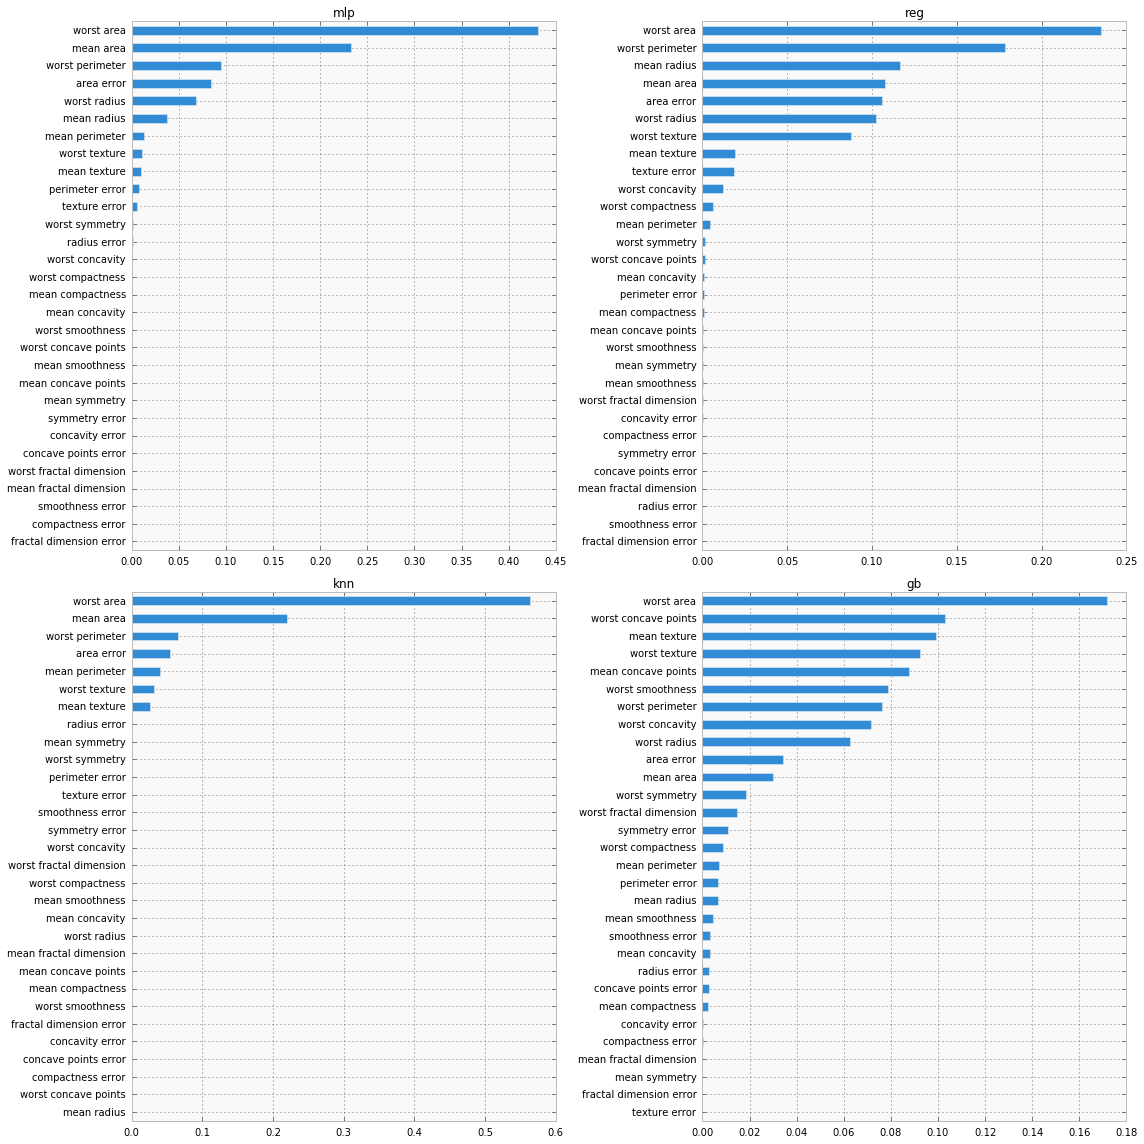

In [8]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyinterpret.core.explanations import Interpretation
from pyinterpret.model import InMemoryModel

f, axes = plt.subplots(2,2, figsize = (16, 16))

ax_dict = {
    'mlp':axes[0][0],
    'knn':axes[1][0],
    'reg':axes[0][1],
    'gb':axes[1][1]
}

interpreter = Interpretation()
interpreter.load_data(X_test, feature_names=data.feature_names)
for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ax=ax)
    ax.set_title(model_key)

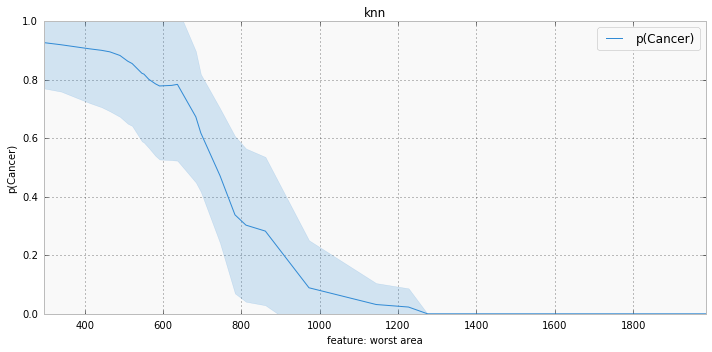

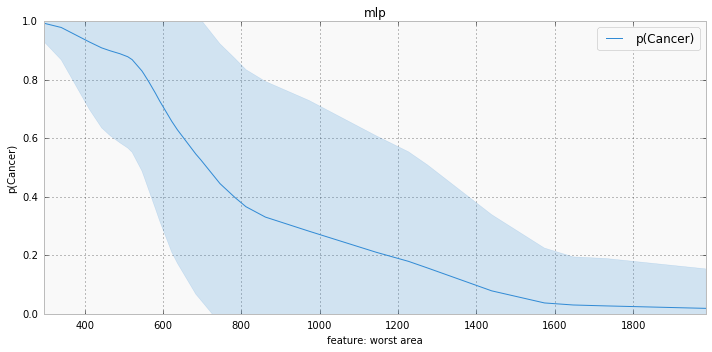

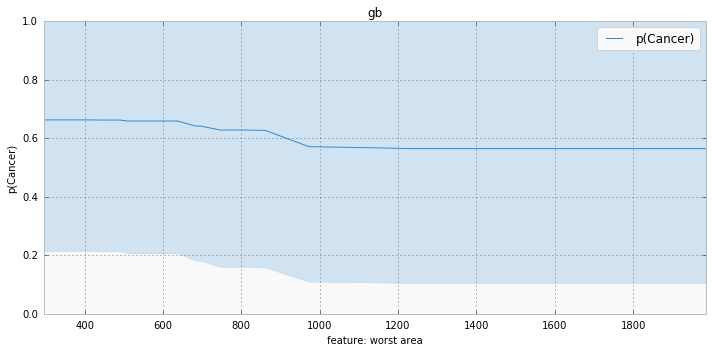

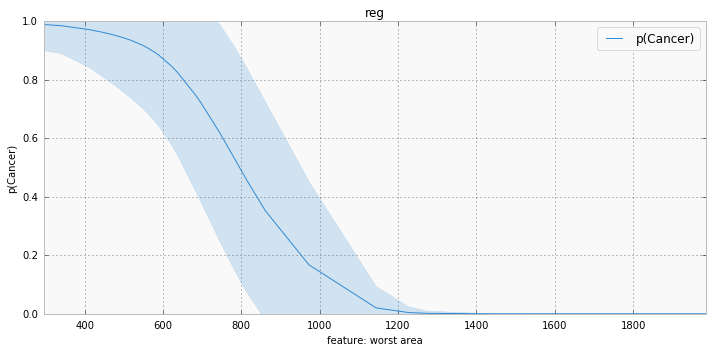

In [15]:
plt.rcParams['figure.figsize'] = (10, 5)
for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train, class_names=['p(No Cancer)', 'p(Cancer)'])
    axes_list = interpreter.partial_dependence.plot_partial_dependence(['worst area'],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                      with_variance=True)
    ax = axes_list[0][0]
    ax.set_title(model_key)
    ax.set_ylim(0, 1)

### Why isnt gb as sensitive to worst area? Feature importance indicates gb uses more features, perhaps theres additivity?

In [37]:
from pyinterpret.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_train, 
                           feature_names=data.feature_names, 
                           discretize_continuous=False, 
                           class_names=['p(No Cancer)', 'p(Cancer)'])
exp.explain_instance(X_train[0], models['gb'].predict_proba).show_in_notebook()

In [38]:

exp.explain_instance(X_train[0], models['knn'].predict_proba).show_in_notebook()

### Interaction between worst area and perimeter for gb model?

[[<matplotlib.figure.Figure at 0x7f78e858f750>,

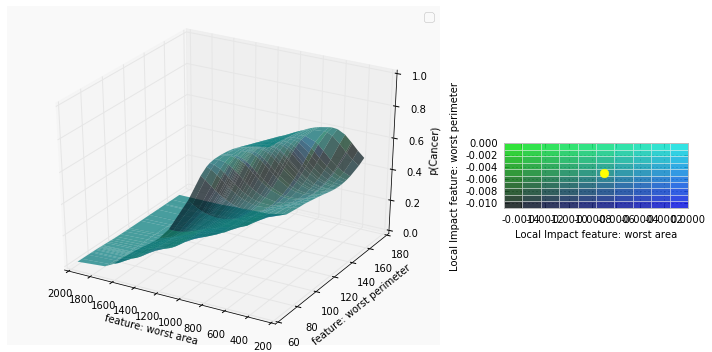

In [32]:
model = InMemoryModel(models[model_key].predict_proba, examples=X_train, class_names=['p(No Cancer)', 'p(Cancer)'])
interpreter.partial_dependence.plot_partial_dependence([('worst area', 'worst perimeter')], model, grid_resolution = 30)